# Andmete Eeltöötlus ja Puhastamine

**Eesmärk:** Töödelda ja puhastada kursuste toorandmeid, et need oleksid valmis filtreerimiseks ja RAG süsteemis kasutamiseks.

**Peamised ülesanded:**
1. JSON formaadis väljade puhastamine ja lihtsamale kujule viimine
2. Kategooriliste veergude ülevaatus ja puhastamine
3. Üldise ja versioonipõhise aine info ühendamine (eelistades versioonipõhist)
4. Koondatud kirjelduse loomine kõigist veergudest RAG süsteemi jaoks

**Sisend:** `toorandmed_aasta.csv`  
**Väljund:** `andmed_puhastatud.csv`

---

### Konsensusel kokkulepitud veerud

**Eelfiltrid** (millised ained välja jätta):
- ✓ Ainult päevaõpe (juba tehtud `toorandmed_aasta.csv`-s)
- ✓ Eemaldada ained, mille kestus > 1 semester (`additional_info__duration_in_semesters`)
- ✓ Eemaldada kaitsmise/lõputöö ained

**Hard-filtrid** (ridade eelfiltreerimiseks enne RAGi):
- `hindamisskaala` ← `additional_info__assessment_scale__et` (eristav/mitteeristav)
- `semester` ← `version__target__semester__et` (kevad/sügis)
- `oppeaste` ← `version__additional_info__study_levels` (bakalaureuse/magistri jne, JSON)
- `oppetoovorm` ← `version__target__study_type__et` (päevaõpe/sessioonõpe jne)
- `keel` ← `version__target__language__et` (õppekeel)
- `linn` ← `version__target__course_main_structural_unit__city` (asukoht, valikuline)

**Kirjeldusse lisatav info:**
- `kirjeldus_et` ← `version__overview__description__et` (eelistame versiooni)
- `eeldusained` ← `additional_info__prerequisites`
- `opitulemused_et` ← `version__overview__learning_outcomes_text_et`
- `hindamise_meetod` ← `version__grading__grade_evaluation__et`

**Tähtis:** Kasutame `code` (mitte `version__code`) ainekoodide jaoks!

## Samm 1: Teekide laadimine ja seadistamine

Laadime vajalikud Pythoni teegid ning seadistame Pandase vaated.

In [1]:
import pandas as pd
import json
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Pandase sätted paremaks loetavuseks
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.width', None)

# Failiteede määramine
INPUT_FILE = 'toorandmed_aasta.csv'
OUTPUT_FILE = 'andmed_puhastatud.csv'

print("Teegid laetud ja seadistatud")
print(f"  Sisend: {INPUT_FILE}")
print(f"  Väljund: {OUTPUT_FILE}")

Teegid laetud ja seadistatud
  Sisend: toorandmed_aasta.csv
  Väljund: andmed_puhastatud.csv


## Samm 2: Toorandmete laadimine

Loeme sisse toorandmed failist ning vaatame andmestiku üldist struktuuri.

In [2]:
if not os.path.exists(INPUT_FILE):
    raise FileNotFoundError(f"Viga: Faili '{INPUT_FILE}' ei leitud!")

# Loeme sisse andmed
df = pd.read_csv(INPUT_FILE, low_memory=False)

print(f"Andmed loetud")
print(f"  Ridu algselt: {df.shape[0]:,}")
print(f"  Veerge: {df.shape[1]:,}")
print(f"\nEsimesed 2 rida:")
df.head(2)

Andmed loetud
  Ridu algselt: 3,416
  Veerge: 229

Esimesed 2 rida:


,course_uuid,code,title__en,version__title__en,credits,overview__description__en,version__overview__description__en,overview__learning_outcomes_text_en,uuid,state__code,state__et,state__en,last_update,title__et,general__input_languages,general__structural_unit_shares,general__type__code,general__type__et,general__type__en,general__structural_units,additional_info__duration_in_semesters,additional_info__assessment_scale__code,additional_info__assessment_scale__et,additional_info__assessment_scale__en,additional_info__is_vota_course,additional_info__is_continuous_learning_course,overview__description__et,overview__objectives,overview__learning_outcomes,_actions__is_editable,_actions__is_version_creatable,_actions__is_deletable,overview__objectives_text_en,version__uuid,version__code,version__state__code,version__state__et,version__state__en,version__last_update,version__title__et,version__credits,version__credit_type,version__target__year__code,version__target__year__et,version__target__year__en,version__target__semester__code,version__target__semester__et,version__target__semester__en,version__target__study_type__code,version__target__study_type__et,version__target__study_type__en,version__target__language__code,version__target__language__et,version__target__language__en,version__target__part__code,version__target__part__et,version__target__part__en,version__target__faculty__code,version__target__faculty__name__en,version__target__faculty__name__et,version__target__faculty__address,version__target__faculty__city,version__target__faculty__level,version__target__faculty__academic,version__target__faculty__supports_continuous_learning,version__target__course_main_structural_unit__code,version__target__course_main_structural_unit__name__en,version__target__course_main_structural_unit__name__et,version__target__course_main_structural_unit__webpage_url,version__target__course_main_structural_unit__address,version__target__course_main_structural_unit__city,version__target__course_main_structural_unit__street,version__target__course_main_structural_unit__zip,version__target__course_main_structural_unit__level,version__target__course_main_structural_unit__academic,version__target__course_main_structural_unit__supports_continuous_learning,version__target__course_main_structural_unit__parent_code,version__target__label__en,version__target__label__et,version__general__year__code,version__general__year__et,version__general__year__en,version__general__input_languages,version__general__structural_unit_shares,version__general__type__code,version__general__type__et,version__general__type__en,version__additional_info__is_vota_course,version__additional_info__is_continuous_learning_course,version__additional_info__study_levels,version__additional_info__hours__lecture,version__additional_info__hours__practice,version__additional_info__hours__seminar,version__additional_info__hours__colloquium,version__additional_info__hours__web_learning,version__additional_info__hours__independent_work,version__additional_info__hours__individual_work,version__additional_info__hours__internship,version__additional_info__is_enlight_course,version__overview__study_languages,version__overview__description__et,version__overview__objectives,version__overview__learning_outcomes,version__grading__independent_work_assessments,version__grading__grade_preconditions__et,version__grading__grade_evaluation__et,version__grading__debt_elimination__et,version__grading__assessment_scale__code,version__grading__assessment_scale__et,version__grading__assessment_scale__en,version__resources__web_based__code,version__resources__web_based__et,version__resources__web_based__en,version__resources__website_url,version__resources__is_moodle_connected,version__resources__learning_environments,version__resources__materials,version__participants__lecturers,version__schedule__weeks__et,version__schedule__entries,version__parent_uuid,version__parent_code,version__parent_credits,version___action

## Samm 2.5: Eelfiltreerimine

Eemaldame read, mida me üldse ei vaja:
1. Aineid, mille kestus on rohkem kui 1 semester
2. Kaitsmise/lõputöö aineid

In [3]:
# Eemaldame ained, mille kestus on > 1 semester
initial_count = len(df)

if 'additional_info__duration_in_semesters' in df.columns:
    df = df[df['additional_info__duration_in_semesters'].isna() | 
            (df['additional_info__duration_in_semesters'] <= 1)]
    print(f"Eemaldatud {initial_count - len(df):,} ainet, mille kestus > 1 semester")

# Eemaldame kaitsmise/lõputöö ained (nt bakalaureuse-/magistritöö, praktiline töö)
if 'general__type__et' in df.columns:
    defense_keywords = ['kaitsmise', 'lõputöö', 'magistritöö', 'bakalaureusetöö', 'doktoritöö']
    defense_mask = df['general__type__et'].fillna('').str.lower().str.contains('|'.join(defense_keywords))
    before_defense = len(df)
    df = df[~defense_mask]
    print(f"Eemaldatud {before_defense - len(df):,} kaitsmise/lõputöö ainet")

print(f"\nRidu pärast eelfiltreerimist: {len(df):,}")

Eemaldatud 459 ainet, mille kestus > 1 semester
Eemaldatud 53 kaitsmise/lõputöö ainet

Ridu pärast eelfiltreerimist: 2,904


## Samm 3: Veergude ühendamine ja valimine

**Probleem:** Andmetes on topeltveergusid - üldine aine info vs aine konkreetse versiooni info.

**Lahendus:** Eelistame alati `version__` prefiksiga veerge, sest need kajastavad tegelikku aineprogrammi. Kui need puuduvad, võtame üldise info.

Näiteks: `version__title__et` ← `title__et`

In [4]:
def resolve_fields(df):
    """
    Loob uued puhtad veerud, eelistades versiooni-põhist infot.
    Tagastab täiendatud DataFrame'i.
    """
    
    # Veerud, kus ühendame üldise ja versiooniinfo (eelistades versiooni)
    # (uus nimi, üldise info veerg, versiooni info veerg)
    merge_mapping = [
        ('nimi_et', 'title__et', 'version__title__et'),
        ('nimi_en', 'title__en', 'version__title__en'),
        ('eap', 'credits', 'version__credits'),
        ('kirjeldus_et', 'overview__description__et', 'version__overview__description__et'),
        ('kirjeldus_en', 'overview__description__en', 'version__overview__description__en'),
        ('opitulemused_et', 'overview__learning_outcomes_text_et', 'version__overview__learning_outcomes_text_et'),
        ('opitulemused_en', 'overview__learning_outcomes_text_en', 'version__overview__learning_outcomes_text_en'),
    ]
    
    # Veerud mis võetakse ühest konkreetsest kohast
    # (uus nimi, vana nimi)
    rename_mapping = [
        ('aine_kood', 'code'),  # Kasutame peamist koodi, mitte versiooni koodi
        ('semester', 'version__target__semester__et'),
        ('oppeaste', 'version__target__study_type__et'),  # PARANDATUD: õige veerg
        ('keel', 'version__target__language__et'),  # Keel (ainult versiooni väljast)
        ('oppetoovorm', 'version__target__study_type__et'),  # Õppetöö vorm (päevaõpe, sessioonõpe jne)
        ('oppeaste_json', 'version__additional_info__study_levels'),  # Õppeastmed JSON (bakalaureuse, magistri)
        ('hindamisskaala', 'additional_info__assessment_scale__et'),  # Eristav/mitteeristav
        ('linn', 'version__target__course_main_structural_unit__city'),
        ('teaduskond', 'version__target__faculty__name__et'),
        ('oppejoud_json', 'version__participants__lecturers'),
        ('toimumisajad_json', 'version__schedule__entries'),
        ('eeldusained_json', 'additional_info__prerequisites'),
        ('hindamise_eeltingimused', 'version__grading__grade_preconditions__et'),
        ('hindamise_meetod', 'version__grading__grade_evaluation__et'),
    ]
    
    print("Alustan veergude filtreerimist ja ühendamist...")
    
    # Ühendame topeltveerud
    for new_col, base, version in merge_mapping:
        base_exists = base in df.columns if base else False
        ver_exists = version in df.columns if version else False
        
        if base_exists and ver_exists:
            df[new_col] = df[version].fillna(df[base])
        elif ver_exists:
            df[new_col] = df[version]
        elif base_exists:
            df[new_col] = df[base]
        else:
            df[new_col] = np.nan
    
    # Võtame otse konkreetsest veerust
    for new_col, source in rename_mapping:
        if source in df.columns:
            df[new_col] = df[source]
        else:
            df[new_col] = np.nan
    
    print("Veergude ühendamine valmis")
    return df
# Rakendame funktsiooni

# Rakendame funktsiooni
df_resolved = resolve_fields(df.copy())

df_resolved[['aine_kood', 'nimi_et', 'semester', 'eap']].head(3)

Alustan veergude filtreerimist ja ühendamist...
Veergude ühendamine valmis


,aine_kood,nimi_et,semester,eap
0,OIEO.06.046,Rahvusvaheline eraõigus,kevad,6.00
2,KKSB.05.092,Praktiseerimine töökeskkonnas,kevad,3.00
3,ARKI.02.030,Lastekirurgia,sügis,2.25


## Samm 4: JSON väljade puhastamine

Teisendame JSON-formaadis veerud (õppejõud, toimumisajad, eeldusained) inimloetavaks tekstiks.

**Näide õppejõudude teisendamisest:**
- **Enne:** `[{"person_name": "Mari Mets", "id": 101}, {"person_name": "Jaan Kask", "id": 102}]`
- **Pärast:** `"Jaan Kask, Mari Mets"`

**Näide eeldusainete teisendamisest:**
- **Enne:** `[{"code": "LOFY.04.073", "title": {"et": "Kvantmehaanika"}, "alternatives": [{"code": "LTFY.04.001", ...}]}]`
- **Pärast:** `"(LOFY.04.073 "Kvantmehaanika") VÕI (LTFY.04.001 "Kvantmehaanika")"`

In [5]:
# Abifunktsioonid JSON töötlemiseks

def parse_json_safe(json_str):
    """Teisendab JSON-stringi turvaliselt Pythoni objektiks."""
    if pd.isna(json_str) or json_str == '': 
        return None
    try:
        return json.loads(json_str)
    except (json.JSONDecodeError, TypeError):
        return None


def extract_lecturers(json_str):
    """Eraldab JSON-struktuurist õppejõudude nimed."""
    data = parse_json_safe(json_str)
    if not data: 
        return None
    names = [p.get('person_name') for p in data if isinstance(p, dict) and p.get('person_name')]
    return ", ".join(sorted(list(set(names)))) if names else None


def extract_schedule_days_et(json_str):
    """
    Analüüsib tunniplaani aegu ja leiab, mis nädalapäevadel aine toimub.
    Teisendab päeva nimed eesti keelde ja sorteerib loogilises järjekorras.
    """
    data = parse_json_safe(json_str)
    if not data: 
        return None
    
    days = set()
    day_map = {
        'Monday': 'Esmaspäev', 
        'Tuesday': 'Teisipäev', 
        'Wednesday': 'Kolmapäev',
        'Thursday': 'Neljapäev', 
        'Friday': 'Reede', 
        'Saturday': 'Laupäev', 
        'Sunday': 'Pühapäev'
    }
    
    for entry in data:
        if not isinstance(entry, dict): 
            continue
        time_str = entry.get('time') or entry.get('start_time')
        if time_str:
            dt = pd.to_datetime(time_str, errors='coerce')
            if not pd.isna(dt):
                en_day = dt.day_name()
                days.add(day_map.get(en_day, en_day))
    
    week_order = ['Esmaspäev', 'Teisipäev', 'Kolmapäev', 'Neljapäev', 'Reede', 'Laupäev', 'Pühapäev']
    sorted_days = sorted(list(days), key=lambda d: week_order.index(d) if d in week_order else 99)
    
    return ", ".join(sorted_days) if sorted_days else None


def extract_study_levels(json_str):
    """
    Eraldab õppeastmete JSON-ist ET nimetused.
    Näide: [{"code": "BAKALAUREUS", "et": "bakalaureuse", ...}] -> "bakalaureuse"
    """
    data = parse_json_safe(json_str)
    if not data:
        return None
    levels = [item.get('et') for item in data if isinstance(item, dict) and item.get('et')]
    return ", ".join(sorted(list(set(levels)))) if levels else None


def extract_prerequisites(json_str):
    """
    Eraldab eeldusainete JSON-ist loetava info.
    Näide: [{"code": "LOFY.04.073", "title": {"et": "Kvantmehaanika"}, "alternatives": [...]}]
    -> '(LOFY.04.073 "Kvantmehaanika") VÕI (LTFY.04.001 "Kvantmehaanika")'
    """
    data = parse_json_safe(json_str)
    if not data:
        return None
    
    if not isinstance(data, list):
        return None
    
    prerequisites = []
    
    for item in data:
        if not isinstance(item, dict):
            continue
        
        # Põhiaine
        code = item.get('code', '')
        title_obj = item.get('title', {})
        
        # Võtame eestikeelse pealkirja, kui puudub siis ingliskeelse
        if isinstance(title_obj, dict):
            title = title_obj.get('et', '') or title_obj.get('en', '')
        else:
            title = ''
        
        # Alternatiivid
        alternatives = item.get('alternatives', [])
        
        # Kui on ainult kood ilma pealkirjata, kasutame ainult koodi
        if code:
            if title:
                options = [f'({code} "{title}")']
            else:
                options = [f'({code})']
            
            # Lisa alternatiivid
            if isinstance(alternatives, list):
                for alt in alternatives:
                    if isinstance(alt, dict):
                        alt_code = alt.get('code', '')
                        alt_title_obj = alt.get('title', {})
                        
                        if isinstance(alt_title_obj, dict):
                            alt_title = alt_title_obj.get('et', '') or alt_title_obj.get('en', '')
                        else:
                            alt_title = ''
                        
                        if alt_code:
                            if alt_title:
                                options.append(f'({alt_code} "{alt_title}")')
                            else:
                                options.append(f'({alt_code})')
            
            # Ühenda "VÕI" sõnaga kui on mitu valikut
            if len(options) > 1:
                prerequisites.append(" VÕI ".join(options))
            elif len(options) == 1:
                prerequisites.append(options[0])
    
    return "; ".join(prerequisites) if prerequisites else None


# Rakendame funktsioonid
print("Ekstraheerime JSON väljadest infot...")

df_resolved['oppejoud'] = df_resolved['oppejoud_json'].apply(extract_lecturers)
df_resolved['toimumisajad'] = df_resolved['toimumisajad_json'].apply(extract_schedule_days_et)
df_resolved['oppeaste'] = df_resolved['oppeaste_json'].apply(extract_study_levels)

# Puhastame eeldusained loetavaks
if 'eeldusained_json' in df_resolved.columns:
    df_resolved['eeldusained'] = df_resolved['eeldusained_json'].apply(extract_prerequisites)
    print("Eeldusained puhastatud loetavale kujule")
else:
    print("Eeldusained veergu ei leitud")

print("JSON töötlemine valmis")
print(f"\nNäide (õppejõud ja toimumisajad):")
df_resolved[['aine_kood', 'oppejoud', 'toimumisajad']].head(3)

# Näitame ka eeldusaineid, kui neid on
if 'eeldusained' in df_resolved.columns:
    courses_with_prereqs = df_resolved[df_resolved['eeldusained'].notna()].head(3)
    if len(courses_with_prereqs) > 0:
        print(f"\nNäide (eeldusained):")
        for idx, row in courses_with_prereqs.iterrows():
            print(f"\n{row['aine_kood']} - {row['nimi_et']}")
            print(f"  Eeldusained: {row['eeldusained']}")
    else:
        print(f"\nEsimesed 3 rida ei sisalda eeldusaineid. Kokku eeldusainetega ridu: {df_resolved['eeldusained'].notna().sum()}")

Ekstraheerime JSON väljadest infot...
Eeldusained puhastatud loetavale kujule
JSON töötlemine valmis

Näide (õppejõud ja toimumisajad):

Näide (eeldusained):

ARKI.02.030 - Lastekirurgia
  Eeldusained: (AR00.00.016 "Diagnostika alused")

LOFY.04.041 - Kvantväljateooria
  Eeldusained: (LOFY.04.073 "Kvantmehaanika") VÕI (LTFY.04.001 "Kvantmehaanika")

LOFY.04.035 - Matemaatilise füüsika võrrandid
  Eeldusained: (LTFY.04.013 "Matemaatiline füüsika") VÕI (LTFY.04.002 "Matemaatiline füüsika")


## Samm 5: Kategooriliste veergude puhastamine

Kontrollime ja puhastame kategooriliste tunnuste veerge (semester, linn, keel, õppeaste jne).

In [6]:
# Puhastame kategoorilised veerud
def clean_categorical_columns(df):
    """Puhastab ja standardiseerib kategoorilised veerud."""
    
    # Eemaldame üleliigsed tühikud
    for col in ['semester', 'linn', 'keel', 'oppeaste', 'oppetoovorm', 'teaduskond', 'hindamisskaala']:
        if col in df.columns:
            df[col] = df[col].astype(str).str.strip()
            df[col] = df[col].replace(['nan', 'None', ''], np.nan)
    
    print("Kategoorilised veerud puhastatud")
    return df

df_resolved = clean_categorical_columns(df_resolved)

# Vaatame kategooriliste veergude unikaalseid väärtusi
print("\nKategooriliste veergude unikaalsed väärtused (HARD-FILTRID):\n")
for col in ['semester', 'hindamisskaala', 'oppeaste', 'oppetoovorm', 'keel', 'linn']:
    if col in df_resolved.columns:
        unique_count = df_resolved[col].nunique()
        print(f"{col}: {unique_count} unikaalset väärtust")
        print(f"  Näited: {df_resolved[col].dropna().unique()[:5].tolist()}")
        print()

Kategoorilised veerud puhastatud

Kategooriliste veergude unikaalsed väärtused (HARD-FILTRID):

semester: 2 unikaalset väärtust
  Näited: ['kevad', 'sügis']

hindamisskaala: 2 unikaalset väärtust
  Näited: ['Eristav (A, B, C, D, E, F, mi)', 'Eristamata (arv, m.arv, mi)']

oppeaste: 23 unikaalset väärtust
  Näited: ['magistriõpe', 'bakalaureuseõpe', 'integreeritud bakalaureuse- ja magistriõpe', 'doktoriõpe, magistriõpe', 'bakalaureuseõpe, magistriõpe']

oppetoovorm: 1 unikaalset väärtust
  Näited: ['päevaõpe']

keel: 2 unikaalset väärtust
  Näited: ['eesti keel', 'inglise keel']

linn: 7 unikaalset väärtust
  Näited: ['Tartu linn', 'Viljandi linn', 'Narva linn', 'Tartu', 'Tõravere alevik']



## Samm 6: Koondatud kirjelduse loomine

Loome uue veeru `kirjeldus`, mis ühendab kõik olulised andmed üheks suureks tekstiks RAG süsteemi jaoks.

In [7]:
def create_full_description(row):
    """
    Ühendab kõik aine andmed üheks koondatud tekstiks RAG süsteemi jaoks.
    Sisaldab: aine info, kirjeldus, eeldusained, õpiväljundid jne.
    """
    parts = []
    
    if pd.notna(row.get('aine_kood')):
        parts.append(f"Aine kood: {row['aine_kood']}")
    
    if pd.notna(row.get('nimi_et')):
        parts.append(f"Nimi (ET): {row['nimi_et']}")
    
    if pd.notna(row.get('nimi_en')):
        parts.append(f"Nimi (EN): {row['nimi_en']}")
    
    if pd.notna(row.get('eap')):
        parts.append(f"EAP: {row['eap']}")
    
    if pd.notna(row.get('semester')):
        parts.append(f"Semester: {row['semester']}")
    
    if pd.notna(row.get('oppeaste')):
        parts.append(f"Õppeastmed: {row['oppeaste']}")
    
    if pd.notna(row.get('oppetoovorm')):
        parts.append(f"Õppetöö vorm: {row['oppetoovorm']}")
    
    if pd.notna(row.get('keel')):
        parts.append(f"Keel: {row['keel']}")
    
    if pd.notna(row.get('hindamisskaala')):
        parts.append(f"Hindamisskaala: {row['hindamisskaala']}")
    
    if pd.notna(row.get('linn')):
        parts.append(f"Linn: {row['linn']}")
    
    if pd.notna(row.get('teaduskond')):
        parts.append(f"Teaduskond: {row['teaduskond']}")
    
    if pd.notna(row.get('oppejoud')):
        parts.append(f"Õppejõud: {row['oppejoud']}")
    
    if pd.notna(row.get('toimumisajad')):
        parts.append(f"Toimumisajad: {row['toimumisajad']}")
    
    # OLULINE INFO RAGi jaoks
    if pd.notna(row.get('kirjeldus_et')):
        parts.append(f"Kirjeldus: {row['kirjeldus_et']}")
    
    if pd.notna(row.get('eeldusained')):
        parts.append(f"Eeldusained: {row['eeldusained']}")
    
    if pd.notna(row.get('opitulemused_et')):
        parts.append(f"Õpitulemused: {row['opitulemused_et']}")
    
    if pd.notna(row.get('hindamise_eeltingimused')):
        parts.append(f"Hindamise eeltingimused: {row['hindamise_eeltingimused']}")
    
    if pd.notna(row.get('hindamise_meetod')):
        parts.append(f"Hindamise meetod: {row['hindamise_meetod']}")
    
    return " | ".join(parts)


# Loome kirjelduse veeru
print("Loome koondatud kirjelduse...")
df_resolved['kirjeldus'] = df_resolved.apply(create_full_description, axis=1)

print("Kirjeldus loodud")
print(f"\nNäide kirjeldusest (esimesed 500 tähemärki):")
print(df_resolved['kirjeldus'].iloc[0][:500] + "...")

Loome koondatud kirjelduse...
Kirjeldus loodud

Näide kirjeldusest (esimesed 500 tähemärki):
Aine kood: OIEO.06.046 | Nimi (ET): Rahvusvaheline eraõigus | Nimi (EN): Private International Law | EAP: 6.0 | Semester: kevad | Õppeastmed: magistriõpe | Õppetöö vorm: päevaõpe | Keel: eesti keel | Hindamisskaala: Eristav (A, B, C, D, E, F, mi) | Linn: Tartu linn | Teaduskond: sotsiaalteaduste valdkond | Õppejõud: Gea Lepik | Kirjeldus: Kursuse raames käsitletakse rahvusvahelise eraõiguse põhiteemasid, terminoloogiat ja kujunemist, tutvustatakse ja õpetatakse praktikas kasutama Eestis kehtivai...


## Samm 7: Lõplike veergude valimine ja salvestamine

Valime välja puhastatud veerud ja salvestame tulemuse.

In [8]:
# Valime lõplikud veerud
# HARD-FILTRID: semester, hindamisskaala, oppeaste, oppetoovorm, keel, linn
# KIRJELDUSSE LISATAV: kirjeldus_et, eeldusained, opitulemused_et
final_cols = [
    'aine_kood',           # Vajalik ÕIS2 lingiks
    'nimi_et',
    'nimi_en',
    'eap',                 # Hard-filter: krediidid
    'semester',            # Hard-filter: kevad/sügis
    'hindamisskaala',      # Hard-filter: eristav/mitteeristav
    'oppeaste',            # Hard-filter: õppeastmed (bakalaureuse, magistri - parsitud JSON)
    'oppetoovorm',         # Hard-filter: õppetöö vorm (päevaõpe, sessioonõpe jne)
    'keel',                # Hard-filter (valikuline): õppekeel
    'linn',                # Hard-filter (valikuline): asukoht
    'teaduskond',
    'oppejoud',
    'toimumisajad',
    'kirjeldus_et',        # Kirjeldusse
    'kirjeldus_en',        # Kirjeldusse (valikuline)
    'eeldusained',         # Kirjeldusse: eeldusained
    'opitulemused_et',     # Kirjeldusse: õpiväljundid
    'opitulemused_en',     # Kirjeldusse (valikuline)
    'hindamise_eeltingimused',
    'hindamise_meetod',    # Võib sisaldada eksami infot
    'kirjeldus'            # Koondatud kirjeldus RAGile
]

# Valime ainult olemasolevad veerud
existing_cols = [c for c in final_cols if c in df_resolved.columns]
df_final = df_resolved[existing_cols].copy()

print(f"Lõplik andmestik koostatud")
print(f"  Ridu: {len(df_final):,}")
print(f"  Veerge: {len(df_final.columns)}")
print(f"\nVeerud: {', '.join(df_final.columns)}")

# Salvestame faili
df_final.to_csv(OUTPUT_FILE, index=False)
print(f"\nAndmed salvestatud faili: {OUTPUT_FILE}")

Lõplik andmestik koostatud
  Ridu: 2,904
  Veerge: 21

Veerud: aine_kood, nimi_et, nimi_en, eap, semester, hindamisskaala, oppeaste, oppetoovorm, keel, linn, teaduskond, oppejoud, toimumisajad, kirjeldus_et, kirjeldus_en, eeldusained, opitulemused_et, opitulemused_en, hindamise_eeltingimused, hindamise_meetod, kirjeldus

Andmed salvestatud faili: andmed_puhastatud.csv


---

# KODUTÖÖ TULEMUSED

Järgnevad kastid näitavad puhastatud andmete kohta vajalikku infot.

---

## 1. Puuduvate väärtuste hulk igas veerus

In [9]:
# Arvutame puuduvad väärtused
missing_values = df_final.isnull().sum()
missing_percent = (df_final.isnull().sum() / len(df_final) * 100).round(2)

missing_df = pd.DataFrame({
    'Veerg': missing_values.index,
    'Puuduvaid väärtusi': missing_values.values,
    'Protsent': missing_percent.values
})

print("=" * 60)
print("PUUDUVATE VÄÄRTUSTE ÜLEVAADE")
print("=" * 60)
print(f"\nKokku ridu andmestikus: {len(df_final):,}\n")
print(missing_df.to_string(index=False))
print("\n" + "=" * 60)

PUUDUVATE VÄÄRTUSTE ÜLEVAADE

Kokku ridu andmestikus: 2,904

                  Veerg  Puuduvaid väärtusi  Protsent
              aine_kood                   0      0.00
                nimi_et                   0      0.00
                nimi_en                   0      0.00
                    eap                   0      0.00
               semester                  14      0.48
         hindamisskaala                   0      0.00
               oppeaste                  48      1.65
            oppetoovorm                  14      0.48
                   keel                  14      0.48
                   linn                1073     36.95
             teaduskond                  14      0.48
               oppejoud                  15      0.52
           toimumisajad                1840     63.36
           kirjeldus_et                   0      0.00
           kirjeldus_en                   0      0.00
            eeldusained                2371     81.65
        opitulemused_

## 2. Kategooriliste tunnustega veergude enim levinud väärtused

Näitame iga kategoorilise tunnuse (HARD-FILTRID) 5 esinemissageduselt levinumat väärtust.

In [10]:
# Kategoorilised veerud (HARD-FILTRID konsensuse järgi)
categorical_cols = ['semester', 'hindamisskaala', 'oppeaste', 'oppetoovorm', 'keel', 'linn']

for col in categorical_cols:
    if col in df_final.columns:
        print("=" * 60)
        print(f"TUNNUS: {col.upper()}")
        print("=" * 60)
        
        value_counts = df_final[col].value_counts().head(5)
        
        for idx, (value, count) in enumerate(value_counts.items(), 1):
            percent = (count / len(df_final) * 100)
            print(f"{idx}. {value}: {count:,} ({percent:.1f}%)")
        
        print()

TUNNUS: SEMESTER
1. kevad: 1,528 (52.6%)
2. sügis: 1,362 (46.9%)

TUNNUS: HINDAMISSKAALA
1. Eristav (A, B, C, D, E, F, mi): 1,728 (59.5%)
2. Eristamata (arv, m.arv, mi): 1,176 (40.5%)

TUNNUS: OPPEASTE
1. bakalaureuseõpe: 905 (31.2%)
2. magistriõpe: 535 (18.4%)
3. bakalaureuseõpe, magistriõpe: 306 (10.5%)
4. integreeritud bakalaureuse- ja magistriõpe: 239 (8.2%)
5. bakalaureuseõpe, doktoriõpe, magistriõpe: 190 (6.5%)

TUNNUS: OPPETOOVORM
1. päevaõpe: 2,890 (99.5%)

TUNNUS: KEEL
1. eesti keel: 2,134 (73.5%)
2. inglise keel: 756 (26.0%)

TUNNUS: LINN
1. Tartu linn: 1,562 (53.8%)
2. Narva linn: 122 (4.2%)
3. Viljandi linn: 104 (3.6%)
4. Pärnu linn: 27 (0.9%)
5. Tõravere alevik: 11 (0.4%)



## 3. "Sissejuhatus andmeteadusesse" aine puhastatud andmed

Otsime ja kuvame "Sissejuhatus andmeteadusesse" aine täieliku puhastatud info loetaval kujul.

In [11]:
# Otsime "Sissejuhatus andmeteadusesse" ainet
course_mask = df_final['nimi_et'].str.contains('Sissejuhatus andmeteadusse', case=False, na=False)
course_data = df_final[course_mask]

if len(course_data) > 0:
    print("=" * 80)
    print("SISSEJUHATUS ANDMETEADUSESSE - PUHASTATUD ANDMED")
    print("=" * 80)
    print()
    
    # Võtame esimese leitud variandi
    course = course_data.iloc[0]
    
    # Kuvame ilusalt vormindatuna
    field_labels = {
        'aine_kood': 'Aine kood',
        'nimi_et': 'Nimi (eesti keeles)',
        'nimi_en': 'Nimi (inglise keeles)',  
        'eap': 'EAP (krediidid)',
        'semester': 'Semester',
        'hindamisskaala': 'Hindamisskaala',
        'oppeaste': 'Õppeastmed',
        'oppetoovorm': 'Õppetöö vorm',
        'keel': 'Õppekeel',
        'linn': 'Linn',
        'teaduskond': 'Teaduskond',
        'oppejoud': 'Õppejõud',
        'toimumisajad': 'Toimumisajad',
    }
    
    for field, label in field_labels.items():
        if field in course.index and pd.notna(course[field]):
            print(f"📍 {label}:")
            print(f"   {course[field]}")
            print()
    
    # Pikemad tekstiväljad eraldi
    if pd.notna(course.get('eeldusained')):
        print(f"📚 Eeldusained:")
        print(f"   {course['eeldusained'][:500]}..." if len(str(course['eeldusained'])) > 500 else f"   {course['eeldusained']}")
        print()
    
    if pd.notna(course.get('kirjeldus_et')):
        print(f"📖 Kirjeldus:")
        print(f"   {course['kirjeldus_et'][:500]}..." if len(str(course['kirjeldus_et'])) > 500 else f"   {course['kirjeldus_et']}")
        print()
    
    if pd.notna(course.get('opitulemused_et')):
        print(f"🎯 Õpitulemused:")
        print(f"   {course['opitulemused_et'][:500]}..." if len(str(course['opitulemused_et'])) > 500 else f"   {course['opitulemused_et']}")
        print()
    
    if pd.notna(course.get('hindamise_meetod')):
        print(f"✅ Hindamise meetod:")
        print(f"   {course['hindamise_meetod'][:500]}..." if len(str(course['hindamise_meetod'])) > 500 else f"   {course['hindamise_meetod']}")
        print()
    
    print("=" * 80)
else:
    print("⚠️ Ainet 'Sissejuhatus andmeteadusesse' ei leitud andmetest!")

SISSEJUHATUS ANDMETEADUSESSE - PUHASTATUD ANDMED

📍 Aine kood:
   SVMJ.04.015

📍 Nimi (eesti keeles):
   Sissejuhatus andmeteadusse ja ärianalüütikasse

📍 Nimi (inglise keeles):
   Introduction to Data Science and Business Analytics

📍 EAP (krediidid):
   6.0

📍 Semester:
   kevad

📍 Hindamisskaala:
   Eristav (A, B, C, D, E, F, mi)

📍 Õppeastmed:
   bakalaureuseõpe

📍 Õppetöö vorm:
   päevaõpe

📍 Õppekeel:
   eesti keel

📍 Teaduskond:
   sotsiaalteaduste valdkond

📍 Õppejõud:
   Andres Võrk, Ariana Paola Cortes Angel, Luca Alfieri, Murad Ismayilzada

📖 Kirjeldus:
   Kursus annab praktilise sissejuhatuse põhilistest andmeteaduse ja ärianalüütika mõistetest. Põhirõhk on meetodite praktilisel rakendamisel koos vajalike tarkvarapaketi R komponentide tutvustanisega ja tulemuste tõlgendamisel.

✅ Hindamise meetod:
   Aines positiivse tulemuse saamiseks peab koguma vähemalt 51p



## 4. Kirjelduse tähemärkide arvu statistika

Analüüsime koondatud `kirjeldus` veeru tähemärkide arvu, et mõista, kui palju infot me RAG süsteemile ette anname.

In [12]:
# Arvutame kirjelduse pikkused tähemärkides
df_final['kirjeldus_pikkus'] = df_final['kirjeldus'].astype(str).str.len()

print("=" * 60)
print("KIRJELDUSE TÄHEMÄRKIDE ARVU STATISTIKA")
print("=" * 60)
print()

# Statistilised näitajad
stats = df_final['kirjeldus_pikkus'].describe()

print(f"Kokku aineid:        {int(stats['count']):,}")
print(f"Keskmine pikkus:     {int(stats['mean']):,} tähemärki")
print(f"Standardhälve:       {int(stats['std']):,} tähemärki")
print(f"Miinimum:            {int(stats['min']):,} tähemärki")
print(f"25% kvartiil:        {int(stats['25%']):,} tähemärki")
print(f"Mediaan (50%):       {int(stats['50%']):,} tähemärki")
print(f"75% kvartiil:        {int(stats['75%']):,} tähemärki")
print(f"Maksimum:            {int(stats['max']):,} tähemärki")
print()
print("=" * 60)

# Leiame mõned näidised
print("\n📊 NÄIDISED:")
print(f"\nLühim kirjeldus ({int(df_final['kirjeldus_pikkus'].min())} tähemärki):")
print(f"   {df_final.loc[df_final['kirjeldus_pikkus'].idxmin(), 'nimi_et']}")
print(f"\nPikim kirjeldus ({int(df_final['kirjeldus_pikkus'].max())} tähemärki):")
print(f"   {df_final.loc[df_final['kirjeldus_pikkus'].idxmax(), 'nimi_et']}")
print(f"\nMediaanpikkusega kirjeldus (~{int(stats['50%'])} tähemärki):")
median_idx = (df_final['kirjeldus_pikkus'] - stats['50%']).abs().idxmin()
print(f"   {df_final.loc[median_idx, 'nimi_et']}")

KIRJELDUSE TÄHEMÄRKIDE ARVU STATISTIKA

Kokku aineid:        2,904
Keskmine pikkus:     1,474 tähemärki
Standardhälve:       644 tähemärki
Miinimum:            213 tähemärki
25% kvartiil:        1,021 tähemärki
Mediaan (50%):       1,346 tähemärki
75% kvartiil:        1,783 tähemärki
Maksimum:            5,340 tähemärki


📊 NÄIDISED:

Lühim kirjeldus (213 tähemärki):
   Antiikkeelte õpetaja põhipraktika

Pikim kirjeldus (5340 tähemärki):
   Matemaatiline statistika (1. osa)

Mediaanpikkusega kirjeldus (~1346 tähemärki):
   Martingaalid


### Visualiseerimine

Kuvame kirjelduste pikkuste jaotuse histogrammina, et näha, kui mitmekesised on meie andmed.

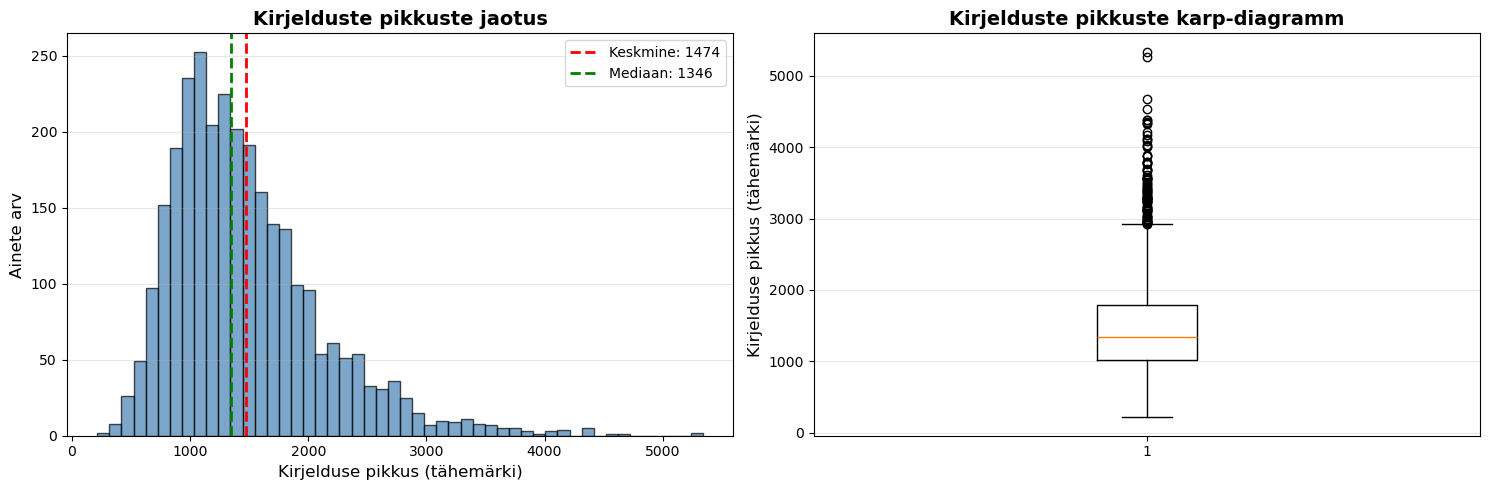


Visualiseering loodud


In [13]:
# Visualiseerime kirjelduste pikkuste jaotust
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogramm
axes[0].hist(df_final['kirjeldus_pikkus'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Kirjelduse pikkus (tähemärki)', fontsize=12)
axes[0].set_ylabel('Ainete arv', fontsize=12)
axes[0].set_title('Kirjelduste pikkuste jaotus', fontsize=14, fontweight='bold')
axes[0].axvline(df_final['kirjeldus_pikkus'].mean(), color='red', linestyle='--', linewidth=2, label=f'Keskmine: {int(df_final["kirjeldus_pikkus"].mean())}')
axes[0].axvline(df_final['kirjeldus_pikkus'].median(), color='green', linestyle='--', linewidth=2, label=f'Mediaan: {int(df_final["kirjeldus_pikkus"].median())}')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Box plot
axes[1].boxplot(df_final['kirjeldus_pikkus'], vert=True)
axes[1].set_ylabel('Kirjelduse pikkus (tähemärki)', fontsize=12)
axes[1].set_title('Kirjelduste pikkuste karp-diagramm', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nVisualiseering loodud")